In [1]:
import kmodels as kmk
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_pickle('../data/LP_Simulations_Formatted.pkl')
df

,Time,FCU,EPL,EPB,FPL,APL,FPB,OPP,Fx,Fy,Fz,ADD,Subject
0,0.000000,0.054566,0.058537,0.062743,0.155728,0.023906,0.021142,0.070465,-9.259692,-4.447818,-6.536988,0.026819,6.26_0.9_1.06
1,0.009799,0.054646,0.058400,0.062911,0.154414,0.023787,0.021018,0.077124,-9.502468,-4.600985,-6.520491,0.026349,6.26_0.9_1.06
2,0.019599,0.054800,0.057753,0.062681,0.153220,0.023763,0.021220,0.095268,-9.513043,-4.624847,-6.518658,0.026434,6.26_0.9_1.06
3,0.029398,0.056122,0.056917,0.063201,0.157919,0.023762,0.022113,0.114959,-9.409544,-4.564386,-6.497891,0.026648,6.26_0.9_1.06
4,0.039197,0.057602,0.056416,0.063981,0.163014,0.023785,0.023148,0.126942,-9.251525,-4.474644,-6.437751,0.026858,6.26_0.9_1.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345171,1.950067,0.077327,0.028705,0.070763,0.186818,0.081797,0.022118,0.090759,-4.916051,-5.716611,-12.003086,0.024750,6.53_1.04_1.02
1345172,1.959866,0.077751,0.027808,0.071065,0.191791,0.082448,0.022103,0.095652,-5.248973,-5.937422,-12.067884,0.024120,6.53_1.04_1.02
1345173,1.969666,0.078584,0.027024,0.071566,0.193814,0.083229,0.022089,0.093776,-5.556444,-6.157407,-12.143441,0.023570,6.53_1.04_1.02
1345174,1.979465,0.078977,0.026315,0.071994,0.195077,0.083762,0.022077,0.086941,-5.809779,-6.380327,-12.206728,0.023072,6.53_1.04_1.02


In [17]:
def split_df_into_subjects(df):
    subject_names = df['Subject'].unique()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = np.split(subject_df.index, time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [np.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]

class Dataset_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        
        # get the subjects from the dataframe
        subjects = split_df_into_subjects(df)
        subject_events = [split_subject_df(subject) for subject in subjects]
        # for each event create a sliding window using the window size and stride
        subject_event_windows = [[sliding_event_df(event, window_size, stride) for event in subject] for subject in subject_events]
        # flatten the list of lists
        subject_event_windows = [window for subject in subject_event_windows for event in subject for window in event]
        self.x_windows = [window[xcols].values for window in subject_event_windows]
        self.y_windows = [window[ycols].values for window in subject_event_windows]
        # save X for an LSTM model. the X shape should be (num_windows, window_size, num_features)
        self.X = np.array([np.expand_dims(x, axis=0) for x in self.x_windows])
        self.X = self.X.reshape(self.X.shape[0], self.X.shape[2], self.X.shape[3])
        # save Y for an LSTM model. the Y shape should be (num_windows, window_size, num_features)
        self.Y = np.array([np.expand_dims(y, axis=0) for y in self.y_windows])
        self.Y = self.Y.reshape(self.Y.shape[0], self.Y.shape[2], self.Y.shape[3])
        # save the number of windows
        self.num_windows = self.X.shape[0]
        # save the number of features
        self.num_features = self.X.shape[2]
        # save the number of outputs
        self.num_outputs = self.Y.shape[2]
        # save all the variables we used to the class
        self.subjects = subjects
        self.subject_events = subject_events
        self.subject_event_windows = subject_event_windows
        self.sort_column = sort_column
    
    def __len__(self):
        return self.num_windows
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        

In [4]:
import dask.dataframe as dd
import dask.array as da
import numpy as np
import torch

class Dataset_LSTM_Parallel(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = dd.from_pandas(df, npartitions=4)
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        self.sort_column = sort_column
        
        self.df = self.df.map_partitions(split_df_into_subjects, meta=(None,))
        self.df = self.df.map_partitions(split_subject_df, meta=(None,))
        self.df = self.df.map_partitions(lambda x: [sliding_event_df(event, window_size, stride) for event in x], meta=(None,))
        self.df = self.df.flatten()
        self.df = self.df.map(lambda x: x[xcols + ycols], meta=(None,))
        self.df = self.df.repartition(npartitions=4)
        
        self.X = da.stack([self.df[xcols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.X = self.X.reshape(-1, window_size, len(xcols))
        self.Y = da.stack([self.df[ycols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.Y = self.Y.reshape(-1, window_size, len(ycols))
        
        self.num_windows = self.X.shape[0]
        self.num_features = self.X.shape[2]
        self.num_outputs = self.Y.shape[2]
        
    def __len__(self):
        return self.num_windows
    
    def __getitem__(self, idx):
        return self.X[idx].compute(), self.Y[idx].compute()

In [5]:
import dask.dataframe as dd
import dask.array as da
import numpy as np
import torch

def split_df_into_subjects_dask(df):
    subject_names = df['Subject'].unique().compute()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df_dask(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values.compute()
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = da.split(subject_df.index.compute(), time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df_dask(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0].compute()
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [da.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]

In [6]:
# first lets split the dataframe into a train and test set using the Subject column. Keep subjects separate during training and testing
#df = dd.from_pandas(df, npartitions=4)
subject_dfs = split_df_into_subjects(df)
train_split = 0.8
n_train_subjects = int(len(subject_dfs) * train_split)
n_test_subjects = len(subject_dfs) - n_train_subjects


In [7]:
n_test_subjects, n_train_subjects

(104, 414)

In [8]:
# randomly pick the subjects to use for training and testing
train_subjects_index = np.random.choice(len(subject_dfs), n_train_subjects, replace=False)
train_df = dd.concat([subject_dfs[i] for i in train_subjects_index])
test_df = dd.concat([subject_dfs[i] for i in range(len(subject_dfs)) if i not in train_subjects_index])

In [9]:
train_df = train_df.compute()
test_df = test_df.compute()
##train_data = Dataset_LSTM(train_df, sort_column=['Subject'], window_size=100, stride=5)
##test_data = Dataset_LSTM(test_df, sort_column=['Subject'], window_size=100, stride=5)

train_data = Dataset_LSTM(train_df, sort_column=['Subject'], window_size=100, stride=5)
test_data = Dataset_LSTM(df, sort_column=['Subject'], window_size=100, stride=5)

In [10]:
train_data.X.shape

(111636, 100, 8)

In [13]:
train_data.X = torch.from_numpy(train_data.X).float()
train_data.Y = torch.from_numpy(train_data.Y).float()

In [16]:
train_data[0]

NotImplementedError: 

NotImplementedError: 

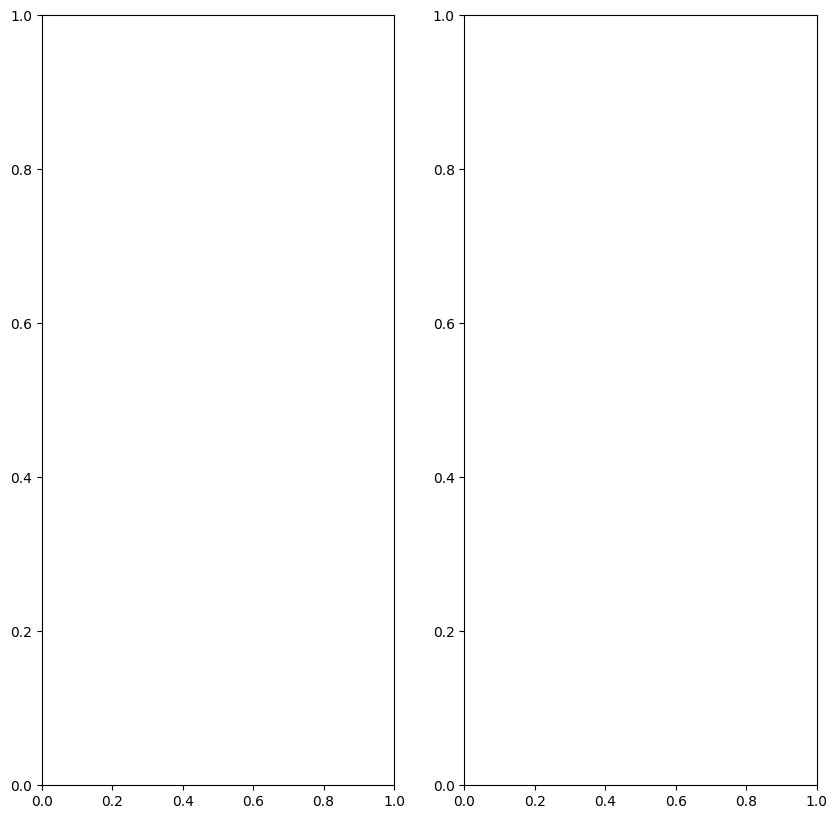

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].plot(train_data[1][0])
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('Mucle Activation')
ax[1].plot(train_data[1][1])
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('Force')

In [18]:
# get relu from pytroch
from torch.nn import functional as F
class lstm(nn.Module):
    def __init__(self, n_inputs=8, hidden_size=30, n_outputs=300, n_linear_layers=1, 
                 layer_size=10, lstm_n_outputs=30):
        super().__init__()
        self.lstm = nn.LSTM(n_inputs, hidden_size, batch_first=True)
        self.fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for i in range(n_linear_layers)])
        self.layer_size = layer_size
        self.n_linear_layers = n_linear_layers 
        self.lstm_n_outputs = lstm_n_outputs
        self.output = nn.Linear(layer_size, n_outputs)
        
    def forward(self, x):
        rows = x.shape[0]
        x, _ = self.lstm(x)
        x = x.reshape(rows, -1)
        for i, fc in enumerate(self.fcs):
            if fc == self.fcs[0]:
                if x.shape[1] != int(fc.in_features):
                    try:    
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size)
                        x = F.relu(self.fcs[0](x))
                    except:
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size).to('cuda')
                        x = F.relu(self.fcs[0](x))
                else:
                    x = F.relu(fc(x))
            else:
                x = F.relu(fc(x))
        x = self.output(x)
        return x
    
 
                

In [19]:
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
model

lstm(
  (lstm): LSTM(8, 30, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=300, bias=True)
)

In [22]:
# PASS A SAMPLE THROUGH TO FIX THE MODEL DIMENSIONS
model(train_data.X[0:10].to('cuda'))
model

lstm(
  (lstm): LSTM(8, 30, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=3000, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=300, bias=True)
)

In [25]:
losses = kmk.run_Pytorch(model, train_data.X.reshape(-1, 100, 8), train_data.Y, n_epochs=200, batch_size=256*4, learning_rate=1e-3)

EPOCH :  0 , dt:  3.2685165405273438 seconds, losses : 3.577589988708496
EPOCH :  10 , dt:  29.547804594039917 seconds, losses : 2.7978665828704834
EPOCH :  20 , dt:  29.389609575271606 seconds, losses : 2.391169786453247
EPOCH :  30 , dt:  29.38090229034424 seconds, losses : 2.2482893466949463
EPOCH :  40 , dt:  29.654438734054565 seconds, losses : 2.1731128692626953
EPOCH :  50 , dt:  29.67127561569214 seconds, losses : 1.8499699831008911
EPOCH :  60 , dt:  32.010249376297 seconds, losses : 1.828102707862854
EPOCH :  70 , dt:  40.603336572647095 seconds, losses : 1.98538339138031
EPOCH :  80 , dt:  43.595818758010864 seconds, losses : 2.681610584259033
EPOCH :  90 , dt:  59.89476728439331 seconds, losses : 2.409099578857422


KeyboardInterrupt: 

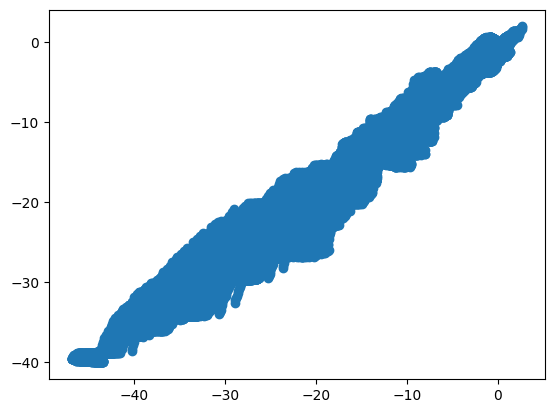

In [28]:
# parity plot
n = 1000
pred = model(train_data.X[0:n].to('cuda')).detach().cpu().numpy().reshape(-1,1)
y = train_data.Y[0:n].detach().cpu().numpy().reshape(-1,1)
plt.scatter(pred, y)

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(y, pred)
mae = mean_absolute_error(y, pred)
mse = mean_squared_error(y, pred)
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


r2:  0.9606000042772169 mae:  0.9760277 mse:  1.935222


r2:  0.968597283407147 mae:  1.1916921 mse:  3.1544058


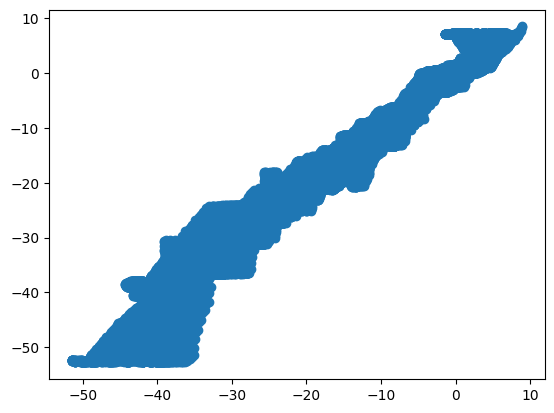

In [34]:
pred = model(torch.from_numpy(test_data.X[0:n]).float().to('cuda')).detach().cpu().numpy().reshape(-1,1)
y_test = torch.from_numpy(test_data.Y[0:n]).float().detach().cpu().numpy().reshape(-1,1)
plt.scatter(pred, y_test)
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


(100, 3)
[-19.018473 -13.231477  -4.33733 ]


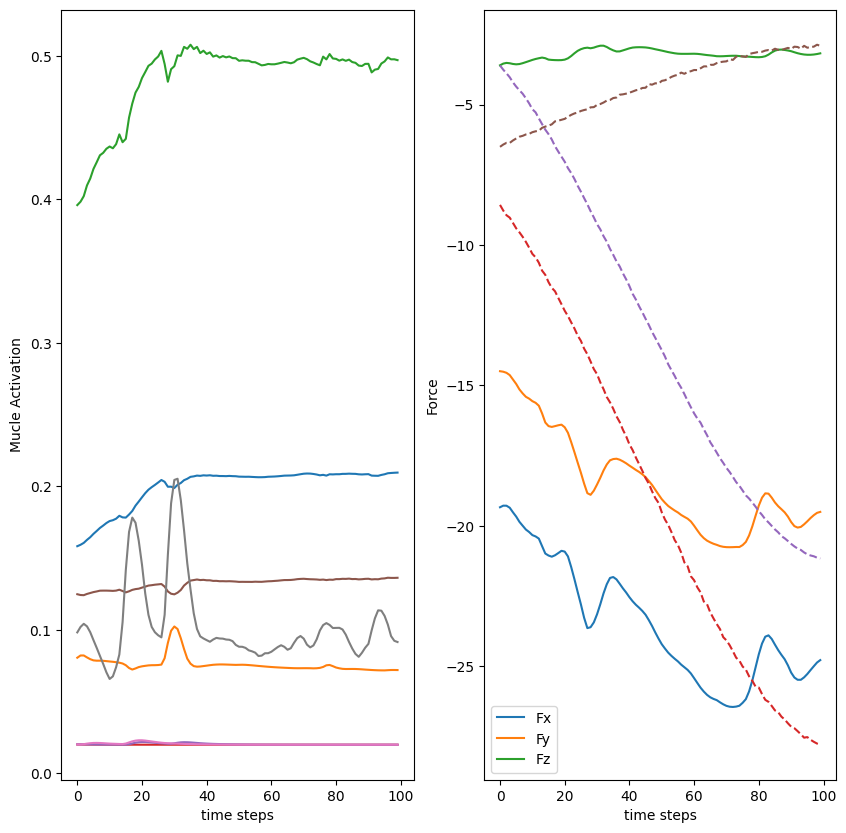

In [38]:
# plot a sample of the data
n = np.random.randint(0, len(test_data.X))
x_plot = torch.from_numpy(test_data.X[n]).float().detach().cpu().numpy()
y_plot = torch.from_numpy(test_data.Y[n]).float().detach().cpu().numpy().reshape(-1, 3)
print(y_plot.shape)
y_labels = test_data.ycols
x_labels = test_data.xcols
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].plot(x_plot)
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('Mucle Activation')
ax[1].plot(y_plot)
    
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('Force')
ax[1].legend(y_labels)
#plot the prediction of this sample
pred = model(torch.from_numpy(test_data.X[0]).float().to('cuda').unsqueeze(0)).detach().cpu().numpy().reshape(-1, 3)
ax[1].plot(pred, '--')
# print the mean prediction on the plot
pred_mean = np.mean(pred, axis=0)
print(pred_mean)

In [47]:
# save the model state dict to the model folder
import os
# import the datetime properly
from datetime import datetime
def save_model(model, name):
    # check if models folder exists
    if not os.path.exists('models'):
        os.mkdir('models')
    torch.save(model.state_dict(), 'models/' + name + '.pt')
# save the model include the todays date
save_model(model, 'lstm_3layer_30nodes_200epochs_' + str(datetime.now().date()))

In [ ]:
# test
plot_lstm_prediction(leave_out_df['Subject'].unique()[0])


In [41]:
model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-4.1161e-02,  1.1054e-01,  1.7201e-01, -2.6799e-01, -7.0242e-02,
                       -2.0842e-01, -1.5441e-01,  1.0312e-01],
                      [ 1.0458e-01,  5.0728e-02, -2.8663e-03,  4.0994e-01,  1.6657e-02,
                        3.6918e-01,  7.1238e-02,  4.3132e-02],
                      [ 1.7774e-01,  1.6343e-01, -5.0060e-02,  6.4623e-02, -1.1973e-03,
                       -3.5068e-01, -1.2250e-02,  3.6427e-02],
                      [ 2.3025e-01,  4.2594e-02,  2.6017e-01, -2.4898e-01, -1.4043e-01,
                        2.9780e-01, -1.7456e-02,  4.1125e-02],
                      [ 1.1278e-01,  3.3643e-01,  3.2499e-01,  4.1851e-01, -1.2136e-01,
                        3.1181e-02, -5.2509e-02, -2.6459e-01],
                      [ 1.6386e-02,  3.1237e-02,  2.0054e-01,  1.8155e-01,  1.9622e-01,
                       -2.8825e-01,  4.2360e-02,  8.4961e-02],
                      [-2.0870e-01,  3.4676e-01,  8.8044e-0